In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg"

In [40]:
#Let's open the dataset and have a look at the columns
dataset = pd.read_csv("Walmart_Store_sales.csv")
dataset.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


# EDA

In [3]:
#8 columns and only 15O lines are in the dataset. Let's see if this will be enough to get correct predictions
dataset.info()
print(dataset.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB
(150, 8)


In [4]:
#It seems there are missings data in the dataset, lets clean it
dataset.isna().sum()/dataset.shape[0]*100

Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

In [41]:
dataset = dataset.dropna()
dataset.isna().sum()/dataset.shape[0]*100

Store           0.0
Date            0.0
Weekly_Sales    0.0
Holiday_Flag    0.0
Temperature     0.0
Fuel_Price      0.0
CPI             0.0
Unemployment    0.0
dtype: float64

In [6]:
dataset.shape
#When removing all NaN, there are only 75 remaining lines

(75, 8)

In [42]:
#Let's transform the date colum
dataset = dataset[dataset["Date"].notna()]
dataset['Date'] = pd.to_datetime(dataset['Date'],format= "%d-%m-%Y")
dataset["Year"] = dataset['Date'].dt.year
dataset['Month'] = dataset['Date'].dt.month
dataset['Day'] = dataset['Date'].dt.day
dataset.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25
4,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28
6,15.0,2011-06-03,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,6,3
7,20.0,2012-02-03,2203523.20,0.0,39.93,3.617,213.023622,6.961,2012,2,3
10,8.0,2011-08-19,895066.50,0.0,82.92,3.554,219.070197,6.425,2011,8,19


In [8]:
dataset.describe()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day
count,75.000000,75,7.500000e+01,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,10.093333,2011-05-29 03:31:12,1.202392e+06,0.093333,60.469600,3.325920,176.073438,7.660453,2010.906667,6.533333,15.586667
min,1.000000,2010-02-05 00:00:00,2.689290e+05,0.000000,18.790000,2.548000,126.114581,5.143000,2010.000000,1.000000,1.000000
25%,4.500000,2010-09-03 00:00:00,5.469425e+05,0.000000,45.465000,2.835000,131.033780,6.597500,2010.000000,4.000000,10.000000
50%,10.000000,2011-05-20 00:00:00,1.074079e+06,0.000000,61.110000,3.435000,192.826069,7.470000,2011.000000,6.000000,16.000000
75%,15.500000,2012-02-27 12:00:00,1.806773e+06,0.000000,75.180000,3.742000,214.703622,8.102500,2012.000000,9.000000,22.000000
max,20.000000,2012-10-19 00:00:00,2.771397e+06,1.000000,91.040000,4.193000,226.968844,14.313000,2012.000000,12.000000,31.000000
std,6.100893,NaN,6.754152e+05,0.292858,17.338982,0.494012,40.155442,1.763908,0.841063,3.120695,8.332764


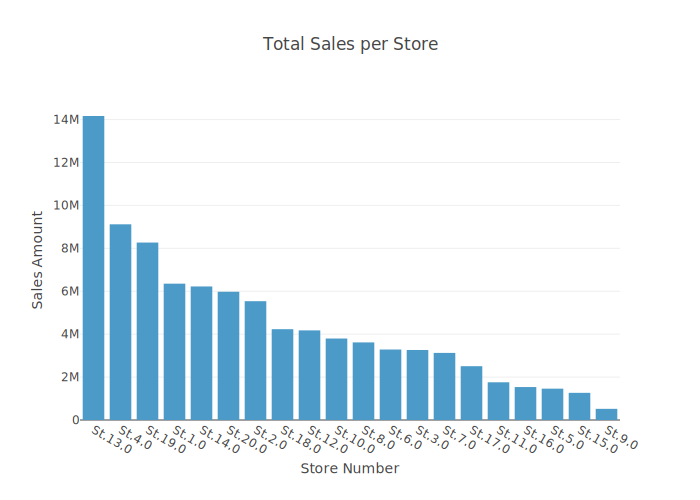

In [9]:
sales_by_store = dataset.groupby(['Store'])['Weekly_Sales'].sum().reset_index()
sales_by_store = sales_by_store.rename(columns={"Weekly_Sales":"Total_Sales"})
sales_by_store['Store'] = "St."+sales_by_store["Store"].astype(str)
sales_by_store = sales_by_store.sort_values(by="Total_Sales",ascending=False)
fig = px.bar(
        sales_by_store,
        x="Store",
        y="Total_Sales",
        title="Total Sales per Store",
        labels={"Store": "Store Number", "Total_Sales": "Sales Amount"})
fig.show()
#There is a large variety in the total sales per store

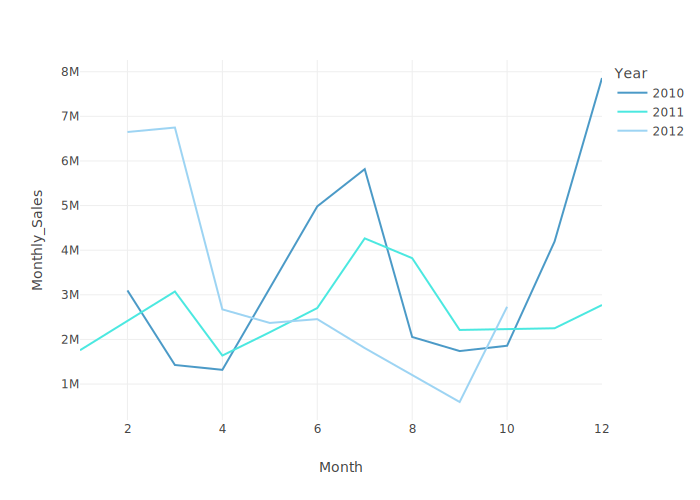

In [10]:
sales_per_month = dataset.groupby(['Year','Month'])['Weekly_Sales'].sum().reset_index()
sales_per_month = sales_per_month.rename(columns={"Weekly_Sales": "Monthly_Sales"})
fig = px.line(sales_per_month,x="Month",y="Monthly_Sales",color="Year")
fig.show()
#There does not seem to be any seasonality as there can have strong discrepencies for the same month between year

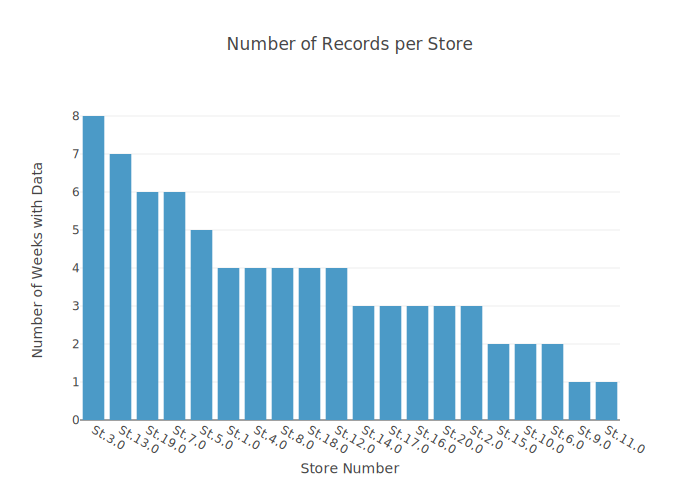

In [ ]:
record_per_store = dataset.groupby(["Store"])['Weekly_Sales'].count().reset_index()

record_per_store = record_per_store.rename(columns={"Weekly_Sales": "Number_Records"})

record_per_store = record_per_store.sort_values(by="Number_Records", ascending=False)

record_per_store['Store'] = "St." + record_per_store["Store"].astype(str)

fig = px.bar(
    record_per_store,
    x="Store",
    y="Number_Records",
    title="Number of Records per Store",
    labels={"Store": "Store Number", "Number_Records": "Number of Weeks with Data"}
)

fig.show()
#No store seems to have complete data as there are maximum 8  records in the dataset of weekly sales

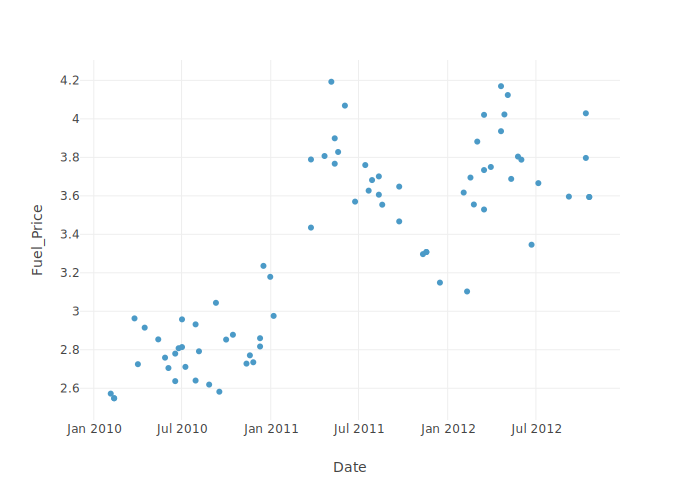

In [70]:
fig = px.scatter(dataset,x="Date",y="Fuel_Price")

fig.show()
#There were a strong variation in the fuel price between 2010 and 20212

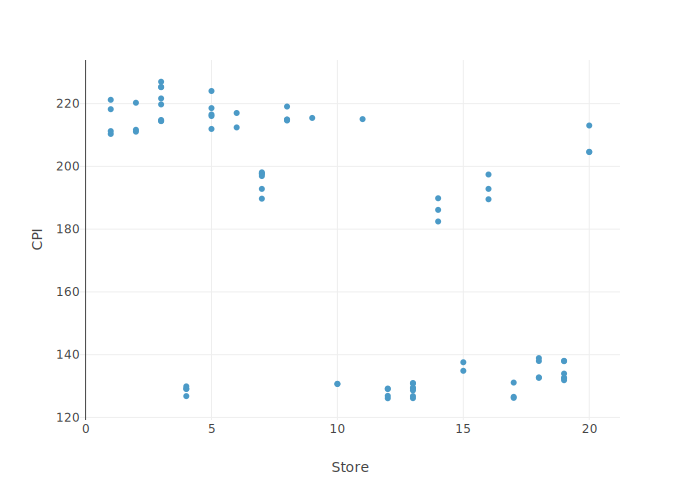

In [ ]:
fig = px.scatter(dataset,x="Store",y="CPI")

fig.show()
#Each store seems to have CPI rate relatively constant in the dataset

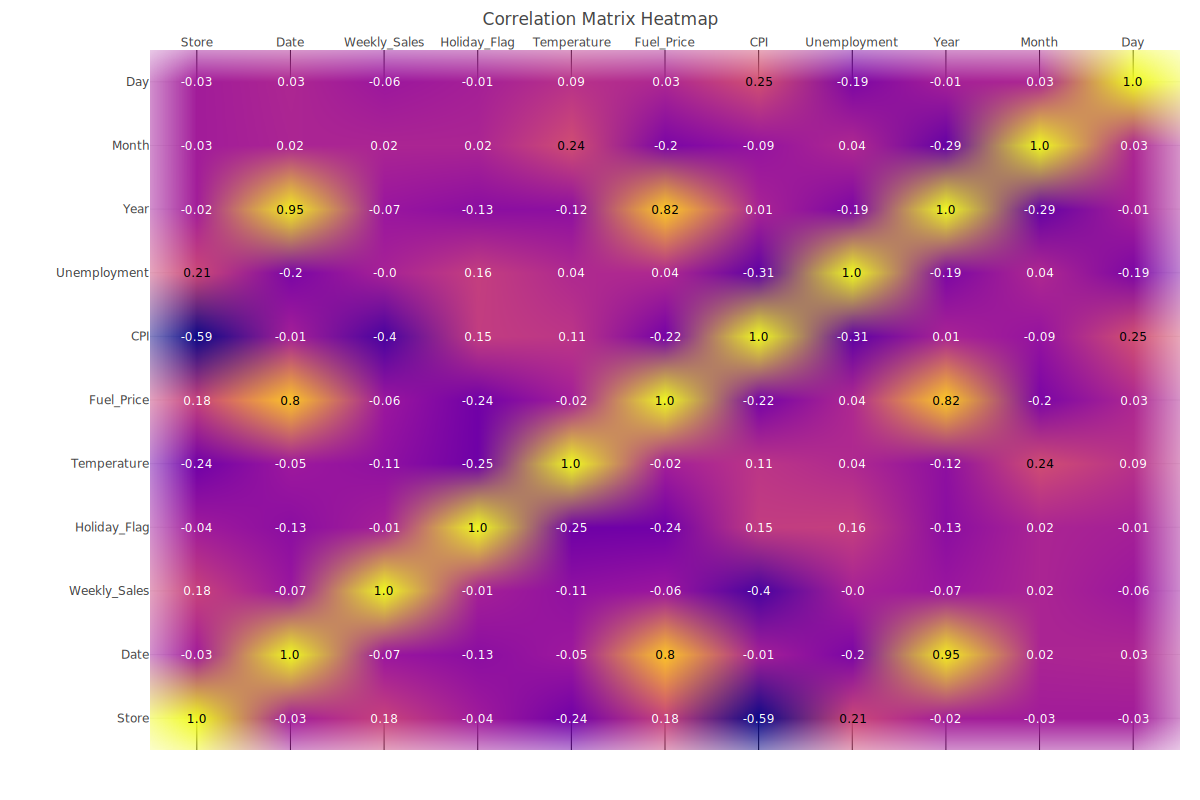

In [ ]:
corr_matrix = dataset.corr().round(2)

import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())

fig.update_layout(
    width=1200, 
    height=800, 
    title="Correlation Matrix Heatmap",
    margin=dict(l=150, r=20, t=50, b=50)  # Adjust the margins (l=left, r=right, t=top, b=bottom)
)
fig.show()

#CPI and store are strongly correlated
#Date and Year are heavily correlated so let's remove the date
#High correlation between fuel price and year but not high enough to be removed

In [43]:
to_drop = ['Date']
dataset.drop(columns=to_drop, inplace=True)
dataset.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28
6,15.0,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,6,3
7,20.0,2203523.20,0.0,39.93,3.617,213.023622,6.961,2012,2,3
10,8.0,895066.50,0.0,82.92,3.554,219.070197,6.425,2011,8,19


# Preprocessing

In [44]:
# Separate target variable Y from features X
target_variable = "Weekly_Sales"

X = dataset.drop(target_variable, axis = 1)
Y = dataset.loc[0:,target_variable]

In [45]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [46]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.items():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

#Actually, let's consider holiday and store as a categorical value
to_remove = ['Holiday_Flag','Store']

# Loop through each item in to_remove and pop it from the numeric_features list
for item in to_remove:
    numeric_features.remove(item)
    categorical_features.append(item)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)


Found numeric features  ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day']
Found categorical features  []
Found numeric features  ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day']
Found categorical features  ['Holiday_Flag', 'Store']


In [47]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())

])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [48]:
# Preprocessings on train set
X_train = preprocessor.fit_transform(X_train)

# Preprocessings on test set
X_test = preprocessor.transform(X_test) # Don't fit again !!

# Train Model

In [49]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [50]:
# Print R^2 scores
print("R2 score on training set : ", regressor.score(X_train, Y_train))
print("R2 score on test set : ", regressor.score(X_test, Y_test))

R2 score on training set :  0.9840484869530072
R2 score on test set :  0.9535857624035171


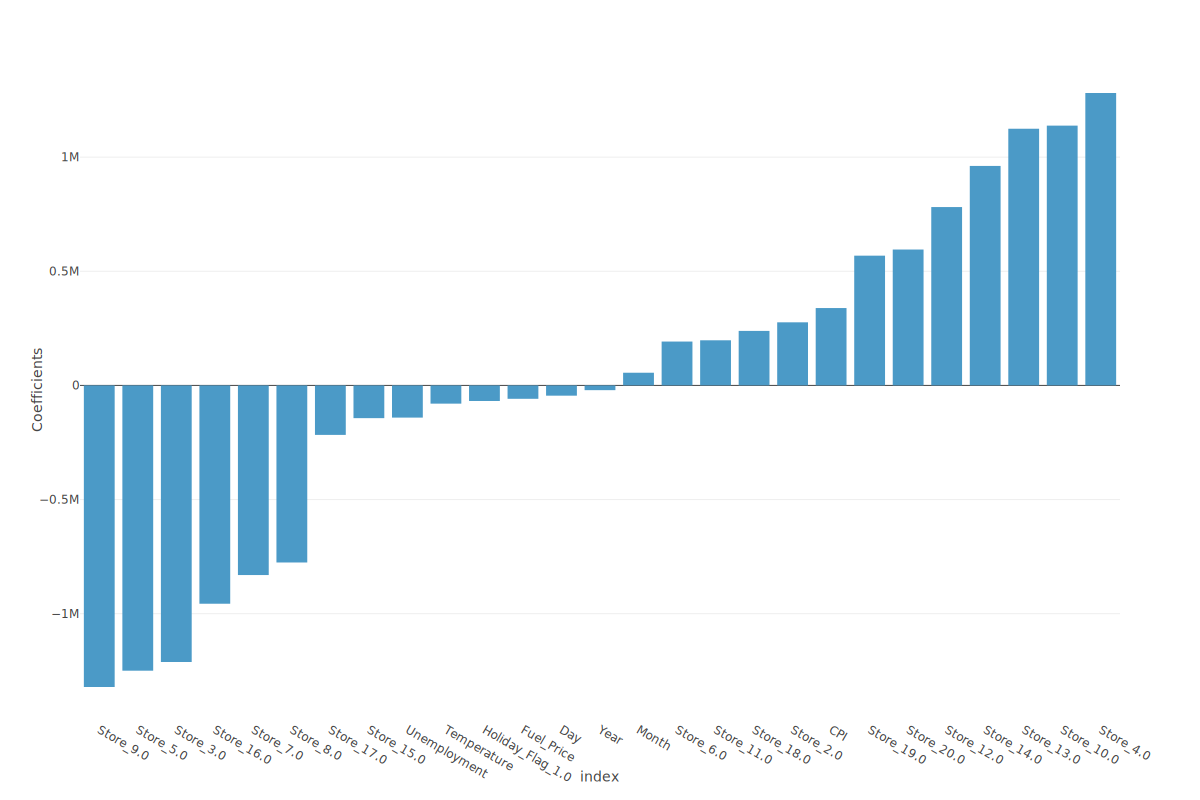

In [51]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())

coefs = pd.DataFrame(
   regressor.coef_,
   columns=['Coefficients'], index=col_names
).reset_index()


fig = px.bar(coefs.sort_values("Coefficients"),x="index",y="Coefficients")
fig.update_layout(
    width=1200, 
    height=800, 
)
fig.show()

#We can see that the store number has a high correlation with the weekly sales, showing that each store has its own sales profile
#The Consumer Price Index is the seconde most important coefficient, which is already linked to the Store


# Regularization Ridge & Lasso

In [55]:
print(X_train[0:5])

  (0, 0)	-0.5733710996691385
  (0, 1)	0.9800355276728914
  (0, 2)	0.6458930267716738
  (0, 3)	0.23289266720135626
  (0, 4)	1.406930010624157
  (0, 5)	-0.5671534357593668
  (0, 6)	1.2946783847855097
  (0, 13)	1.0
  (1, 0)	0.3593030204661926
  (1, 1)	-0.7710505149430401
  (1, 2)	-0.9672801637027159
  (1, 3)	0.23803147487874513
  (1, 4)	-1.0758876551829464
  (1, 5)	0.08102191939419526
  (1, 6)	-1.536789398105145
  (1, 25)	1.0
  (2, 0)	1.0875635794472627
  (2, 1)	0.8889624947235992
  (2, 2)	0.36205194947083924
  (2, 3)	0.5383662346905711
  (2, 4)	0.1655211777206053
  (2, 5)	0.08102191939419526
  (2, 6)	0.06360543570261626
  (2, 20)	1.0
  (3, 0)	0.8998368396117165
  (3, 1)	-1.5493109783278995
  (3, 2)	1.0745557703778779
  (3, 3)	-0.7805944025058511
  (3, 4)	-1.0758876551829464
  (3, 5)	0.7291972745477574
  (3, 6)	0.3098200255191949
  (3, 14)	1.0
  (4, 0)	-1.6019944423870818
  (4, 1)	-1.6196855946978066
  (4, 2)	1.0681806697962504
  (4, 3)	-0.7897300605989865
  (4, 4)	-1.0758876551829464
  (

In [56]:
#Let's have a grid search for ridge

print("Ridge Grid search....")
ridge_regressor = Ridge()
params = {
    'alpha' : [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
}

best_ridge = GridSearchCV(ridge_regressor, param_grid=params, cv= 5)
best_ridge.fit(X_train,Y_train)
print("...Done.")
print("Best hyperparameters : ", best_ridge.best_params_)
print("Best R2 score : ", best_ridge.best_score_)

# Perform Lasso grid search
print("LAsso Grid search...")
lasso_regressor = Lasso()
# Grid of values to be tested
params = {
    'alpha': [1, 2, 3, 5, 10, 20, 30]
}
best_lasso = GridSearchCV(lasso_regressor, param_grid = params, cv = 5) # cv : the number of folds to be used for CV
best_lasso.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", best_lasso.best_params_)
print("Best R2 score : ", best_lasso.best_score_)

Ridge Grid search....
...Done.
Best hyperparameters :  {'alpha': 0.1}
Best R2 score :  0.8037523203240514
LAsso Grid search...


c:\Users\Utilisateur\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 140759964764.0859, tolerance: 2242474430.631906

c:\Users\Utilisateur\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 130144268804.49155, tolerance: 1952207656.7702723

c:\Users\Utilisateur\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 119147286484.28069, tolerance: 1948158547.0797584

c:\Users\Utilisateur\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality ga

...Done.
Best hyperparameters :  {'alpha': 30}
Best R2 score :  0.7683068968368004


c:\Users\Utilisateur\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 48049297642.73697, tolerance: 2128854469.0145328

c:\Users\Utilisateur\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 47628343808.79416, tolerance: 2245370266.2249985

c:\Users\Utilisateur\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 127466641593.36813, tolerance: 2635500819.590337



In [57]:
# Print R^2 scores
print("RIDGE / R2 score on training set : ", best_ridge.score(X_train, Y_train))
print("RIDGE / R2 score on test set : ", best_ridge.score(X_test, Y_test))
print()
print("LASSO / R2 score on training set : ", best_lasso.score(X_train, Y_train))
print("LASSO / R2 score on test set : ", best_lasso.score(X_test, Y_test))

#Performance on the R2 has not been improved by the regression

RIDGE / R2 score on training set :  0.9804935138599221
RIDGE / R2 score on test set :  0.9540164690492989

LASSO / R2 score on training set :  0.9839357034759957
LASSO / R2 score on test set :  0.9492413938671039


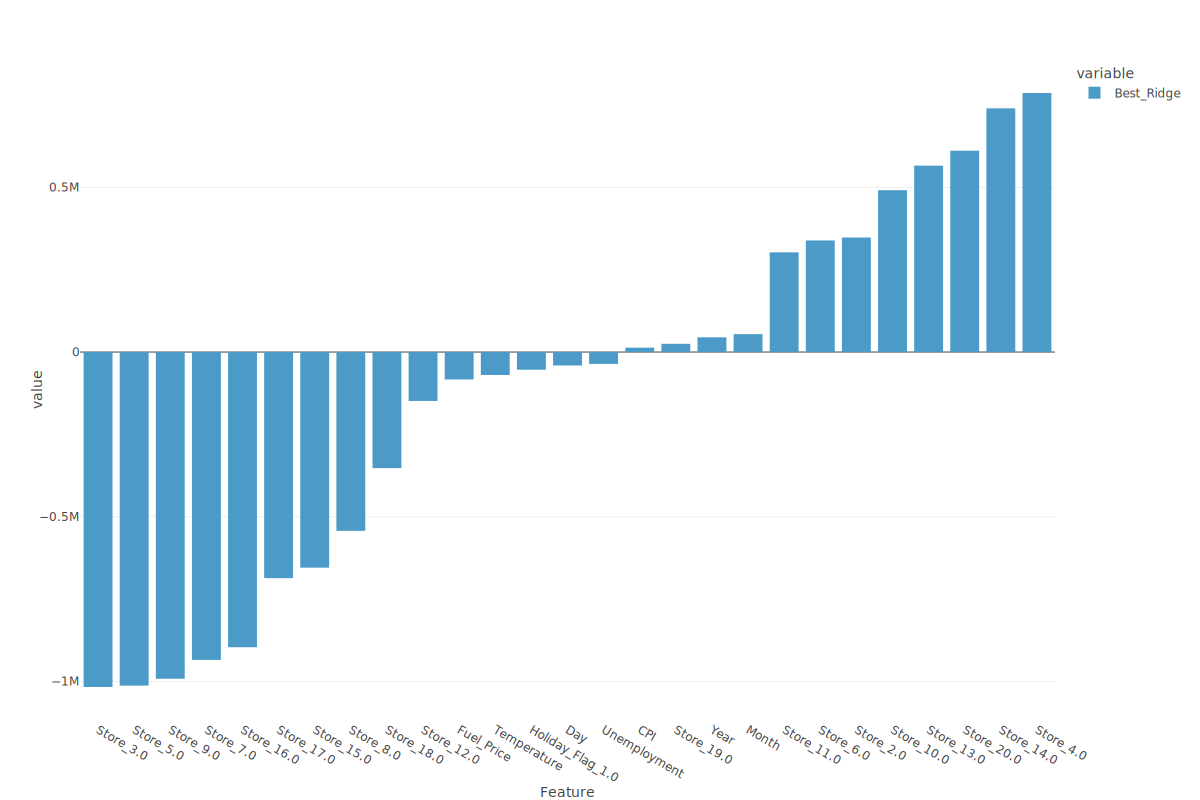

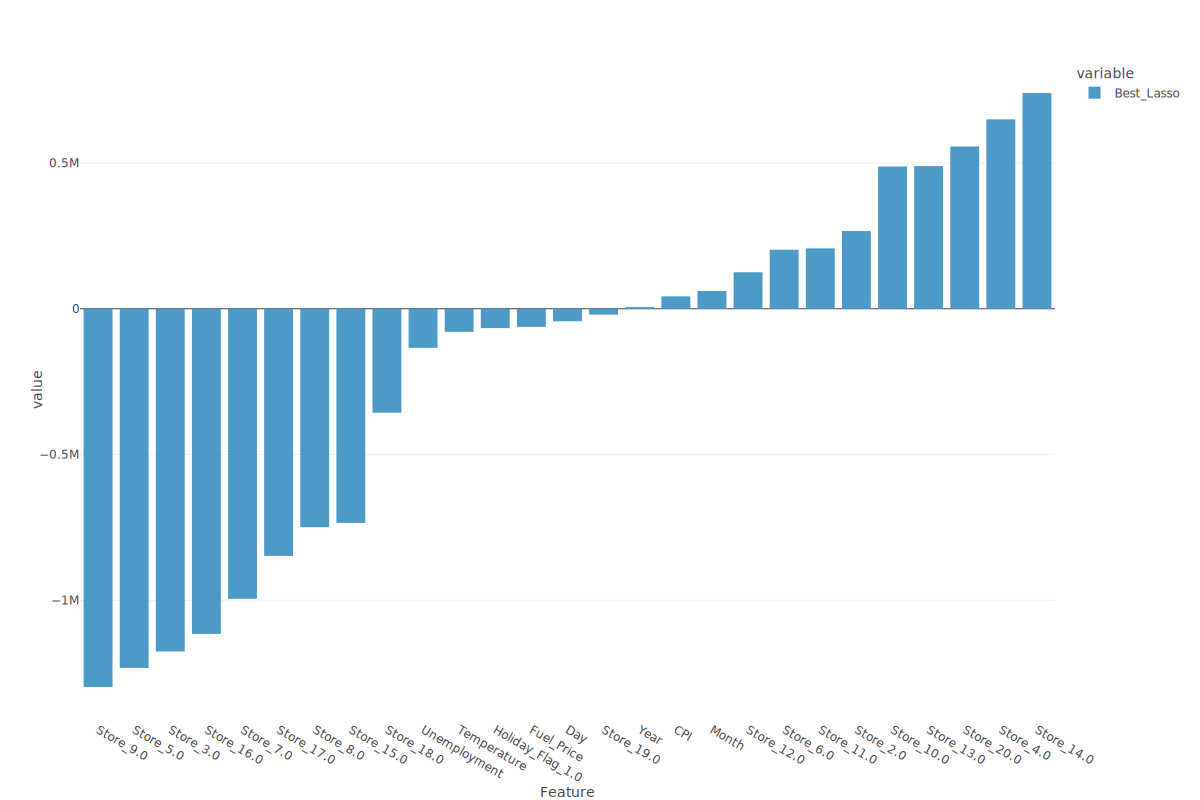

In [60]:
data_dict = {
    'Feature': col_names,
    'Best_Ridge': best_ridge.best_estimator_.coef_,
    'Best_Lasso': best_lasso.best_estimator_.coef_,
    'Initial Regression' : regressor.coef_
            }

coefficients = pd.DataFrame(data = data_dict)

fig = px.bar(coefficients.sort_values('Best_Ridge'), x = 'Feature', y = ['Best_Ridge'])
fig.update_layout(
    width=1200, 
    height=800, 
)
fig.show()

fig = px.bar(coefficients.sort_values('Best_Lasso'), x = 'Feature', y = ['Best_Lasso'])
fig.update_layout(
    width=1200, 
    height=800, 
)
fig.show()

#Lasso and Ridge seems to have limited impact on the regression
#Overall, it seems that we are missing datapoints to fully predict. We have only 150 datapoints for 20 store, which seems to have their own specificities

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def plot_coefficient_comparison(df):
    # Get the number of features/coefficients
    n_features = len(df)
    
    # Create positions for the bars
    ind = np.arange(n_features)
    width = 0.25  # Width of the bars
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create bars for each model
    bar1 = ax.bar(ind - width, df['Best_Ridge'], width, label='Best_Ridge', alpha=0.7)
    bar2 = ax.bar(ind, df['Best_Lasso'], width, label='Best_Lasso', alpha=0.7)
    bar3 = ax.bar(ind + width, df['Initial Regression'], width, label='Initial Regression', alpha=0.7)
    
    # Add labels and title
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Coefficient Value', fontsize=12)
    ax.set_title('Comparison of Model Coefficients', fontsize=16)
    
    # Set x-ticks in the middle of the groups
    ax.set_xticks(ind)
    ax.set_xticklabels(df['Feature'], rotation=45, ha='right')
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add a legend
    ax.legend()

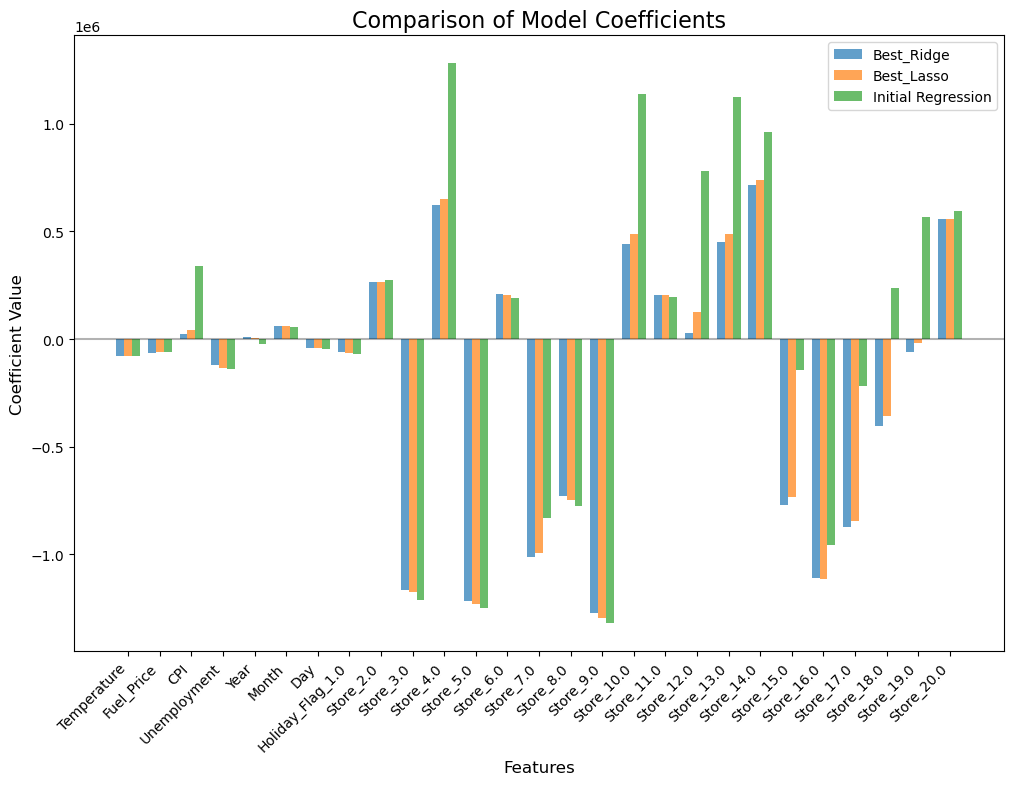

In [58]:
plot_coefficient_comparison(coefficients)

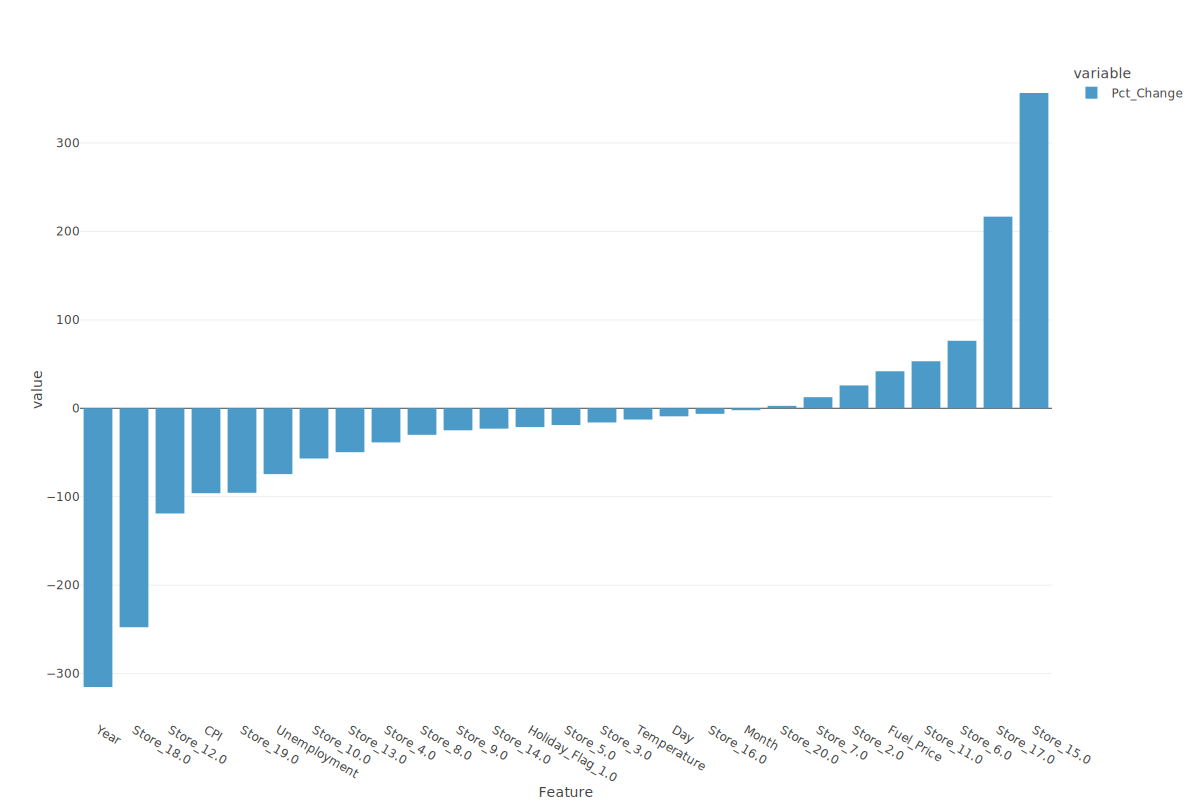

In [68]:
# Calculate percentage change from Initial Regression to Best_Ridge
coefficients['Pct_Change'] = ((coefficients['Best_Ridge'] - coefficients['Initial Regression']) / 
                   coefficients['Initial Regression']) * 100




fig = px.bar(coefficients.sort_values('Pct_Change'), x = 'Feature', y = ['Pct_Change'])
fig.update_layout(
    width=1200, 
    height=800, 
)
fig.show()


In [69]:
print(coefficients.to_string(float_format='{:.2f}'.format))


             Feature  Best_Ridge  Best_Lasso  Initial Regression  Pct_Change
0        Temperature   -69666.71   -79301.52           -79844.99      -12.75
1         Fuel_Price   -83198.94   -62255.09           -58657.54       41.84
2                CPI    13305.29    42343.64           338922.45      -96.07
3       Unemployment   -35996.11  -134212.59          -141019.47      -74.47
4               Year    44797.70     5610.97           -20816.02     -315.21
5              Month    54333.66    60820.93            55553.39       -2.20
6                Day   -40826.61   -42962.69           -44925.16       -9.12
7   Holiday_Flag_1.0   -53718.44   -66528.83           -68260.20      -21.30
8          Store_2.0   347723.86   266451.58           276380.44       25.81
9          Store_3.0 -1017036.72 -1175498.15         -1211682.89      -16.06
10         Store_4.0   786536.24   649563.22          1281021.20      -38.60
11         Store_5.0 -1012786.02 -1231940.12         -1249767.36      -18.96

# Improvements

Overall, we found a way to predict it but it seems that it is mainly correlated to the store himself. So if the we use it for a new store, we would not be able to anticipate what would be the sales


As the store are linked to a location, let's try to create category of each columns and test if this improve the performance

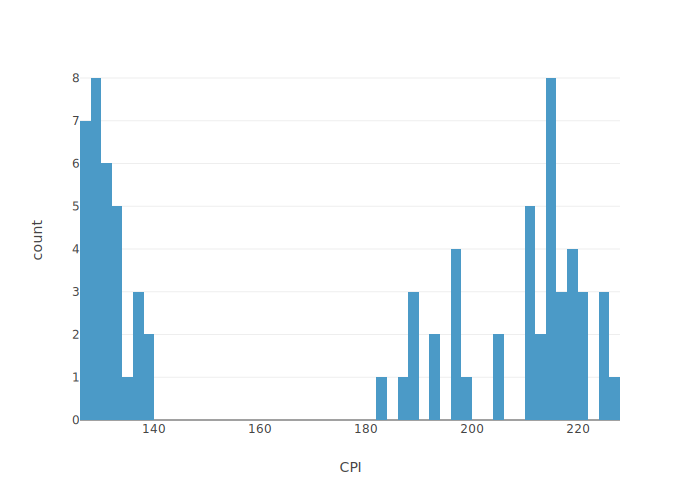

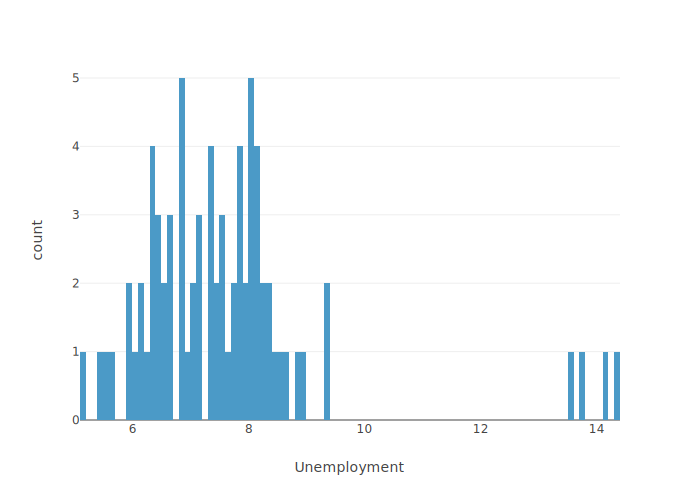

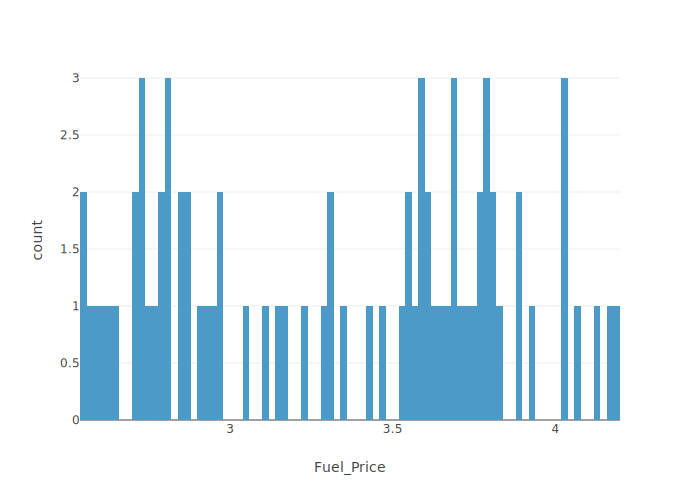

In [89]:
for c in ['CPI',"Unemployment", "Fuel_Price"]:
    fig = px.histogram(dataset, x=c, nbins=100)
    fig.show()

In [90]:
# Create CPI category
def categorize_cpi(cpi_value):
    if cpi_value < 140:
        return 'Low'
    elif cpi_value <= 200:
        return 'Medium'
    else:
        return 'High'

# Create Unemployment category
def categorize_unemployment(unemployment_value):
    if unemployment_value < 7:
        return 'Low'
    elif unemployment_value <= 12:
        return 'Medium'
    else:
        return 'High'

# Apply categorization to dataset
dataset['CPI_Category'] = dataset['CPI'].apply(categorize_cpi)
dataset['Unemployment_Category'] = dataset['Unemployment'].apply(categorize_unemployment)

dataset.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,CPI_Category,Unemployment_Category,FuelPrice_Category,Store_Category
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25,Low,Medium,Medium,Unemployment_Medium_CPI_Low
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28,High,Medium,Low,Unemployment_Medium_CPI_High
6,15.0,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,6,3,Low,Medium,High,Unemployment_Medium_CPI_Low
7,20.0,2203523.20,0.0,39.93,3.617,213.023622,6.961,2012,2,3,High,Low,Medium,Unemployment_Low_CPI_High
10,8.0,895066.50,0.0,82.92,3.554,219.070197,6.425,2011,8,19,High,Low,Medium,Unemployment_Low_CPI_High


before categorizing the fuel, let's check if there are changes by store for the same given period

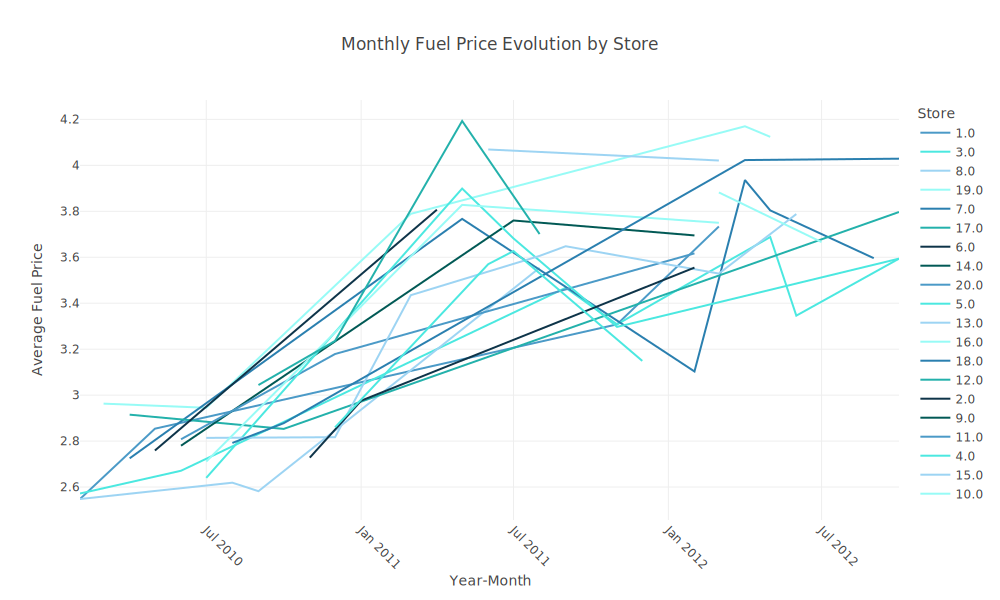

In [91]:
fuel_by_month = dataset.groupby(['Year', 'Month', 'Store'])['Fuel_Price'].mean().reset_index()

# Create a chronological order for x-axis
fuel_by_month['YearMonth'] = fuel_by_month['Year'].astype(str) + '-' + fuel_by_month['Month'].astype(str).str.zfill(2)

# Create line chart
fig = px.line(fuel_by_month, 
              x='YearMonth', 
              y='Fuel_Price', 
              color='Store',
              title='Monthly Fuel Price Evolution by Store',
              labels={
                  'Fuel_Price': 'Average Fuel Price',
                  'YearMonth': 'Year-Month',
                  'Store': 'Store'
              })

# Improve x-axis layout
fig.update_xaxes(tickangle=45)
fig.update_layout(height=600, width=1000)
fig.show()

In [92]:
# Create Fuel  category
def categorize_fuelprice(fuelprice_value):
    if fuelprice_value < 3:
        return 'Low'
    elif fuelprice_value <= 3.8:
        return 'Medium'
    else:
        return 'High'



# Apply categorization to dataset
dataset['FuelPrice_Category'] = dataset['Fuel_Price'].apply(categorize_fuelprice)
dataset.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,CPI_Category,Unemployment_Category,FuelPrice_Category,Store_Category
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25,Low,Medium,Medium,Unemployment_Medium_CPI_Low
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28,High,Medium,Low,Unemployment_Medium_CPI_High
6,15.0,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,6,3,Low,Medium,High,Unemployment_Medium_CPI_Low
7,20.0,2203523.20,0.0,39.93,3.617,213.023622,6.961,2012,2,3,High,Low,Medium,Unemployment_Low_CPI_High
10,8.0,895066.50,0.0,82.92,3.554,219.070197,6.425,2011,8,19,High,Low,Medium,Unemployment_Low_CPI_High


In [93]:
#Lets try to see if the holiday has any impact


# Group by Store and Holiday_Flag to get average sales
store_holiday = dataset.groupby(['Store', 'Holiday_Flag'])['Weekly_Sales'].agg(['mean', 'std', 'count']).reset_index()

# Create a more intuitive Holiday column
store_holiday['Holiday_Status'] = store_holiday['Holiday_Flag'].map({0: 'Non-Holiday', 1: 'Holiday'})

# Create a pivot table for easier comparison
store_pivot = store_holiday.pivot(index='Store', columns='Holiday_Status', values='mean').reset_index()

# Calculate absolute and percentage differences
store_pivot['Absolute_Diff'] = store_pivot['Holiday'] - store_pivot['Non-Holiday']
store_pivot['Percent_Diff'] = (store_pivot['Absolute_Diff'] / store_pivot['Non-Holiday'] * 100).round(2)

# Sort by percentage difference to see which stores benefit most from holidays
store_pivot_sorted = store_pivot.sort_values('Percent_Diff', ascending=False)

store_pivot_sorted

Holiday_Status,Store,Holiday,Non-Holiday,Absolute_Diff,Percent_Diff
6,7.0,580668.66,4.913298e+05,89338.905000,18.18
7,8.0,994801.40,8.735304e+05,121271.023333,13.88
0,1.0,1641957.44,1.570403e+06,71554.780000,4.56
19,20.0,1799737.79,2.088330e+06,-288591.745000,-13.82
11,12.0,903119.03,1.090891e+06,-187772.140000,-17.21
1,2.0,NaN,1.845555e+06,NaN,NaN
2,3.0,NaN,4.078440e+05,NaN,NaN
3,4.0,NaN,2.279620e+06,NaN,NaN
4,5.0,NaN,2.920532e+05,NaN,NaN
5,6.0,NaN,1.641915e+06,NaN,NaN


In [94]:
dataset.groupby(['Holiday_Flag'])['Weekly_Sales'].count().reset_index()

#In total, the number of holiday week is very small to be taken into account

,Holiday_Flag,Weekly_Sales
0,0.0,68
1,1.0,7


In [95]:
# Create a more descriptive Store_Category 
dataset['Store_Category'] = 'Unemployment_' + dataset['Unemployment_Category'] + '_CPI_' + dataset['CPI_Category']
dataset.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,CPI_Category,Unemployment_Category,FuelPrice_Category,Store_Category
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25,Low,Medium,Medium,Unemployment_Medium_CPI_Low
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28,High,Medium,Low,Unemployment_Medium_CPI_High
6,15.0,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,6,3,Low,Medium,High,Unemployment_Medium_CPI_Low
7,20.0,2203523.20,0.0,39.93,3.617,213.023622,6.961,2012,2,3,High,Low,Medium,Unemployment_Low_CPI_High
10,8.0,895066.50,0.0,82.92,3.554,219.070197,6.425,2011,8,19,High,Low,Medium,Unemployment_Low_CPI_High


Let's try to use this store category and train the model based on this category 

In [96]:
#As we will test several dataset, let's write a function to train it

def train_function(dataset_train,target_variable,list_column_to_remove= []):
    X = dataset_train.drop(target_variable, axis = 1)
    Y = dataset_train.loc[0:,target_variable]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

    # Automatically detect names of numeric/categorical columns
    numeric_features = []
    categorical_features = []
    for i,t in X.dtypes.items():
        if ('float' in str(t)) or ('int' in str(t)) :
            numeric_features.append(i)
        else :
            categorical_features.append(i)

    print('Found numeric features ', numeric_features)
    print('Found categorical features ', categorical_features)

    # Loop through each item in to_remove and pop it from the numeric_features list
    for item in list_column_to_remove:
        numeric_features.remove(item)
        categorical_features.append(item)

    print('Found numeric features ', numeric_features)
    print('Found categorical features ', categorical_features)

    # Create pipeline for numeric features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
        ('scaler', StandardScaler())

    ])

    # Create pipeline for categorical features
    categorical_transformer = Pipeline(
        steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
        ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
        ])

    # Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    print("preprocessing data...")
    # Preprocessings on train set

    X_train = preprocessor.fit_transform(X_train)


    # Preprocessings on test set
    X_test = preprocessor.transform(X_test) # Don't fit again !!
    print("...preprocessing done")


    # Train model
    print("Train model...")
    regressor = LinearRegression()
    regressor.fit(X_train, Y_train)
    print("...Done.")

    # Print R^2 scores
    print("R2 score on training set : ", regressor.score(X_train, Y_train))
    print("R2 score on test set : ", regressor.score(X_test, Y_test))

In [97]:
dataset_train = dataset[["Weekly_Sales","Temperature","Month","CPI_Category","Unemployment_Category","FuelPrice_Category","Store_Category"]]

target_variable = "Weekly_Sales"

train_function(dataset_train,"Weekly_Sales" )



Found numeric features  ['Temperature', 'Month']
Found categorical features  ['CPI_Category', 'Unemployment_Category', 'FuelPrice_Category', 'Store_Category']
Found numeric features  ['Temperature', 'Month']
Found categorical features  ['CPI_Category', 'Unemployment_Category', 'FuelPrice_Category', 'Store_Category']
preprocessing data...
...preprocessing done
Train model...
...Done.
R2 score on training set :  0.27828225129603257
R2 score on test set :  0.30893615186474666


The performance is not good at all with this methodology.

As it is linked to the number of store, let's try to cluster directlu the store and then make prediction based on forecast. For this, we will take the average of each colums per store, use a K-MEAN to find the cluster and put it back in the dataset to make linear regression

WCSS for K=1 --> 140.0
WCSS for K=2 --> 90.31895988099289
WCSS for K=3 --> 67.10976934176843
WCSS for K=4 --> 64.45822159566328
WCSS for K=5 --> 47.20184951229529
WCSS for K=6 --> 36.28455467391133
WCSS for K=7 --> 32.931594890120365
WCSS for K=8 --> 21.118391688561083
WCSS for K=9 --> 17.341233512202585
WCSS for K=10 --> 14.233013815830638


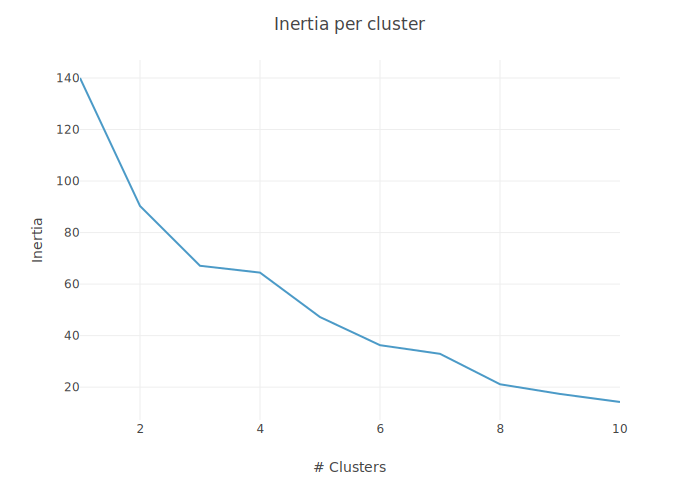

In [100]:
from sklearn.cluster import KMeans

# Aggregate data at store level
store_features = dataset.groupby('Store').agg({
    'Weekly_Sales': ['mean',  'min', 'max'],
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean'
}).reset_index()

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(store_features.iloc[:, 1:])

wcss =  []
k = []
for i in range (1,11):
    kmeans = KMeans(n_clusters= i, random_state = 0, n_init = 'auto')
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)
    k.append(i)
    print("WCSS for K={} --> {}".format(i, wcss[-1]))

import plotly.express as px

# Create DataFrame
wcss_frame = pd.DataFrame(wcss)
k_frame = pd.Series(k)

# Create figure
fig= px.line(
    wcss_frame,
    x=k_frame,
    y=wcss_frame.iloc[:,-1]
)

# Create title and axis labels
fig.update_layout(
    yaxis_title="Inertia",
    xaxis_title="# Clusters",
    title="Inertia per cluster"
)

# Render
#fig.show(renderer="notebook")
fig.show() # if using workspace


Silhouette score for K=2 is 0.2914110650592411
Silhouette score for K=3 is 0.2798154673439513
Silhouette score for K=4 is 0.1608601395446853
Silhouette score for K=5 is 0.1840947091715292
Silhouette score for K=6 is 0.21795705835827306
Silhouette score for K=7 is 0.1472371782152595
Silhouette score for K=8 is 0.2572721082269812
Silhouette score for K=9 is 0.24894202662068446
Silhouette score for K=10 is 0.24484326288299335


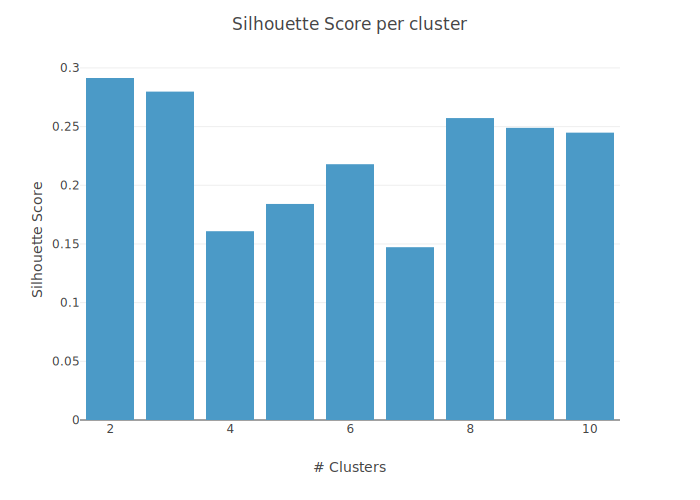

In [101]:
# Import silhouette score
from sklearn.metrics import silhouette_score

# Computer mean silhouette score
sil = []
k = []

## Careful, you need to start at i=2 as silhouette score cannot accept less than 2 labels
for i in range (2,11):
    kmeans = KMeans(n_clusters= i, random_state = 0, n_init = 'auto')
    kmeans.fit(scaled_features)
    sil.append(silhouette_score(scaled_features, kmeans.predict(scaled_features)))
    k.append(i)
    print("Silhouette score for K={} is {}".format(i, sil[-1]))

# Create a data frame
cluster_scores=pd.DataFrame(sil)
k_frame = pd.Series(k)

# Create figure
fig = px.bar(data_frame=cluster_scores,
             x=k,
             y=cluster_scores.iloc[:, -1]
            )

# Add title and axis labels
fig.update_layout(
    yaxis_title="Silhouette Score",
    xaxis_title="# Clusters",
    title="Silhouette Score per cluster"
)

# Render
#fig.show(renderer="notebook")
fig.show() # if using workspace

4 seems to be the best number of clusters to use

In [106]:
from sklearn.cluster import KMeans

#Aggregate data at store level
store_features = dataset.groupby('Store').agg({
    'Weekly_Sales': ['mean', 'min', 'max'],
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean'
}).reset_index()

#Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(store_features.iloc[:, 1:])

#Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=0)
store_features['Cluster'] = kmeans.fit_predict(scaled_features)

store_features

Store  Weekly_Sales                         Temperature Fuel_Price  \
                  mean         min         max        mean       mean   
0    1.0  1.588291e+06  1494251.50  1677472.78   60.070000   3.111000   
1    2.0  1.845555e+06  1758050.79  1916812.74   53.003333   3.086333   
2    3.0  4.078440e+05   364076.85   461622.22   72.898750   3.164625   
3    4.0  2.279620e+06  2008344.92  2771397.17   60.882500   3.301500   
4    5.0  2.920532e+05   268929.03   313358.15   75.828000   3.422400   
5    6.0  1.641915e+06  1639358.93  1644470.66   76.565000   3.283000   
6    7.0  5.211094e+05   414094.05   597876.55   40.233333   3.488500   
7    8.0  9.038481e+05   836707.85   994801.40   66.625000   2.825750   
8    9.0  5.198233e+05   519823.30   519823.30   49.960000   2.771000   
9   10.0  1.898185e+06  1805999.79  1990371.02   72.245000   3.774000   
10  11.0  1.757243e+06  1757242.51  1757242.51   69.900000   2.735000   
11  12.0  1.043948e+06   903119.03  1295605.35   73.960000   3.543500   
12  13.0  2.023731e+06  1807545.43  2461468.35   58.734286   3.376714   
13  14.0  2.074247e+06  1953544.76  2248645.59   62.646667   3.411667   
14  15.0  6.330037e+05   570611.23   695396.19   58.610000   4.045000   
15  16.0  5.115820e+05   435397.19   614253.33   51.343333   3.429667   
16  17.0  8.356081e+05   757738.76   919878.34   50.036667   3.188333   
17  18.0  1.057750e+06   961186.23  1166117.85   56.772500   3.430500   
18  19.0  1.378183e+06  1255087.26  1549018.68   52.895000   3.489333   
19  20.0  1.992132e+06  1799737.79  2203523.20   47.983333   3.201333   

           CPI Unemployment Cluster  
          mean         mean          
0   215.252979     7.782000       0  
1   214.333910     7.749333       0  
2   220.325272     7.022500       2  
3   128.727135     5.965000       3  
4   217.419409     6.247200       2  
5   214.713791     6.973500       0  
6   195.476131     8.311000       2  
7   215.876613     6.338500       2  
8   215.437285     6.560000       2  
9   130.682713     7.357500       3  
10  215.061403     7.564000       0  
11  127.810020    13.933000       3  
12  128.864857     7.005571       3  
13  186.141628     8.649333       3  
14  136.219774     7.800500       1  
15  193.255923     6.456333       2  
16  127.968344     6.349000       2  
17  135.566845     8.805000       3  
18  134.483065     8.103167       3  
19  207.411465     7.433667       0

In [112]:
#Let's reopen the dataset to remove the previous clustering
dataset = pd.read_csv("Walmart_Store_sales.csv")
dataset = dataset[dataset["Date"].notna()]
dataset['Date'] = pd.to_datetime(dataset['Date'],format= "%d-%m-%Y")
dataset["Year"] = dataset['Date'].dt.year
dataset['Month'] = dataset['Date'].dt.month
dataset['Day'] = dataset['Date'].dt.day
dataset = dataset.dropna()
to_drop = ['Date']
dataset.drop(columns=to_drop, inplace=True)

# First, let's extract just the Store and Cluster columns from store_features
# Notice how we access MultiIndex columns using tuples
store_clusters = store_features[('Store', '')]
clusters = store_features[('Cluster', '')]

# Create a simple DataFrame with just these two columns
mapping_df = pd.DataFrame({
    'Store': store_clusters,
    'Cluster': clusters
})

# Now merge this simplified DataFrame with your original dataset
# Assuming your original dataset has a column named 'store'
merged_dataset = pd.merge(
    dataset,
    mapping_df,
    on='Store',
    how='left'
)

merged_dataset.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,Cluster
0,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25,3
1,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28,0
2,15.0,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,6,3,1
3,20.0,2203523.20,0.0,39.93,3.617,213.023622,6.961,2012,2,3,0
4,8.0,895066.50,0.0,82.92,3.554,219.070197,6.425,2011,8,19,2


In [114]:

dataset_train = merged_dataset[["Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment","Month", "Year","Day","Cluster"]]

target_variable = "Weekly_Sales"

train_function(dataset_train,"Weekly_Sales",['Cluster'] )


Found numeric features  ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Month', 'Year', 'Day', 'Cluster']
Found categorical features  []
Found numeric features  ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Month', 'Year', 'Day']
Found categorical features  ['Cluster']
preprocessing data...
...preprocessing done
Train model...
...Done.
R2 score on training set :  0.8446923718243229
R2 score on test set :  0.8789354515924618


The performance has not been improved with the clustering

# Conclusion

## Data Insights
- The dataset was relatively small with only 150 initial records, which reduced to 75 records after removing missing values.
- There was significant variation in sales between different stores, indicating each store has a unique sales profile.
- No clear seasonality was observed in monthly sales patterns across years.
- Data completeness was an issue, with a maximum of only 8 weekly records per store.

## Model Performance
- The initial Linear Regression model achieved reasonable performance, primarily driven by store-specific attributes.
- The store number and CPI were identified as the strongest predictors of weekly sales.
- Regularization techniques (Ridge and Lasso) did not significantly improve the model's performance, suggesting the model wasn't overfitting despite the small dataset.
- Attempts to categorize variables (CPI, unemployment, fuel price) and cluster stores based on their characteristics did not enhance predictive power.

## Limitations
- The small sample size (75 complete records across 20 stores) severely limited the model's ability to generalize.
- Store-specific effects dominated the predictions, which would make forecasting for new stores challenging.
- The limited number of observations per store made it difficult to identify temporal patterns or seasonal effects.

## Recommendations
1. **Data Collection**: Gather more historical sales data to increase the dataset size and improve model robustness.
2. **Feature Engineering**: Explore additional features that might influence sales, such as promotional events, product categories, or local economic indicators.
3. **Store Segmentation**: Instead of trying to fit a one-size-fits-all model, develop store-specific or cluster-specific models that account for the unique characteristics of different store locations.
4. **Time Series Approach**: Consider time series forecasting methods that might better capture the temporal dynamics of sales data.
